<i>STATUS: Draft<i>

In [1]:
import numpy as np
import sympy as sp
from IPython.display import HTML
import matplotlib.pyplot as plt
from matplotlib import animation
from matplotlib.patches import Rectangle, Circle, ConnectionPatch
from IPython.display import Image
import sys
import pandas as pd
import HTM_Code as hc
import colorsys
import time as timer

So we now have a sense of a number of things: 

* We can create SDRS
* We have mechanimsm to evaluate more than 1 SDRs
* We have a way to deal with fault tolerance and add noise to SDRs
* We have encoder which takes a value in and encodes it in a numerical way that semantics
* We have a multi numerical encoder that allows us to join a numbrer of numerical encoders
* We have some nice visualisation functions

I have put them into into code file which for now we will just keep as one big file. 

We now come to the next big component of a HTM system: The Spatial Pooler (SP). From the literature: 

<i>The SP models how neurons learn feedforward connections and form efficient represetntnations of the input. It convers arbitrary binary input patterns into sparse distributed representations (SDRs) using a comintation of competitive Hebbian leanig rules and homeostatic excitability control</i>

There is an awful lot in the that sentence, and the best way forward is tackle things with an example, and develop our understanding. Our resource, will be HTM school along with a couple of key papers: 

* HTM Spatial Pooler - Neocortical Algorthm for Online Sparse Distributed Encoding
* BAMI - Chapter on spatial pooler. 

In [2]:
HTML('<iframe width="560" height="315" src="https://www.youtube.com/embed/R5UoFNtv5AU" title="YouTube video player" frameborder="0" allow="accelerometer; autoplay; clipboard-write; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>')

To get an understanding of the Spatial Pooler, we will also use some data, which comes from a classic example used in HTM, tracking the power consuptiom in a gymnasium over time. Let's import the data and have a look at it: 

In [3]:
df = pd.read_csv("./data/gymdata.csv", header=1)
df = df.rename(columns={"datetime": "date_time", "float": "power_consumption"})
df = df.iloc[1:]
df.head()

,date_time,power_consumption
1,7/2/10 0:00,21.2
2,7/2/10 1:00,16.4
3,7/2/10 2:00,4.7
4,7/2/10 3:00,4.7
5,7/2/10 4:00,4.6


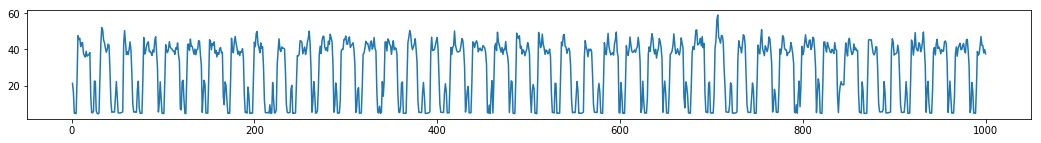

In [4]:
df.power_consumption[:1000].plot(figsize = (18,2))

This gives us a bit of a sense of how things look from record to record. I will do bit of work on the data set, just to clean up the columns, to seperate date and time, and create an indicator of whether its weekend or not, so the data can easily be placed in an encodeer

In [5]:
df.date_time = pd.to_datetime(df.date_time, format="%m/%d/%y %H:%M")
df['date'] = [d.date() for d in df.date_time]
df['time_of_day'] = [d.time() for d in df.date_time]
df['weekday'] = [d.weekday() for d in df.date]
df['is_weekend'] = df.loc[df.weekday < 4, 'weekday'] = 0
df['is_weekend'] = df.loc[df.weekday >= 4, 'weekday'] = 1
df = df.drop('date_time', axis=1)
df = df.drop('weekday', axis=1)

df.head()

,power_consumption,date,time_of_day,is_weekend
1,21.2,2010-07-02,00:00:00,1
2,16.4,2010-07-02,01:00:00,1
3,4.7,2010-07-02,02:00:00,1
4,4.7,2010-07-02,03:00:00,1
5,4.6,2010-07-02,04:00:00,1


We have also added some more terms to our glossary, so let's bring that in too and sort it by spatial pooler tag:

In [6]:
glossary = pd.read_csv("./data/glossary.csv", header=0)
glossary.loc[glossary['Tags'].str.contains("spatial pooler")].style.set_properties(**{'text-align': 'left'})

,Tags,Term,Description
0,spatial pooler,Column,"An HTM region is organized in columns of cells. The SP operates at the column-level, where a column of a cells function as a single computational unit."
1,spatial pooler,Inhibition,The mechanism for maintaining sparse activations of neurons. In the SP this manifests as columns inhibiting nearby columns from becoming active.
2,spatial pooler,Inhibition radius,"The size of a column's local neighborhood, within which columns may inhibit each other from becoming active."
3,spatial pooler,Active duty cycle,A moving average denoting the frequency of column activation.
4,spatial pooler,Overlap duty cycle,A moving average denoting the frequency of the column's overlap value being at least equal to the proximal segment activation threshold.
5,spatial pooler,Receptive field,The input space that a column can potentially connect to
6,spatial pooler,Permance value,"indicates the amount of growth between a mini-column in the Spatial Pooling algorithm and one of the cells in its receptive field. Acceptable values are [0,1]."
7,spatial pooler,Permance threshold,"If a synapse's permanence is above this value, it is considered fully connected."
8,spatial pooler; neuroscience,Synapse,"A junction between cells. In the Spatial Pooling algorithm, synapses on a column's dendritic segment connect to bits in the input space. A synapse can be in the following states: Connected: permanence is above the threshold, Potential: permanence is below the threshold, Unconnected: does not have the ability to connect."


- An SDR arrives at the neocortex through the thalumus
- Neocortex is structuced into regions and in each of these regions is columns of cells (montcastle)
- each column has associated dendritic segment which is the connection to the input space
- each dendrectic segment has potential synapses representing a random subset of input bits


spatial pooling.....

biology of neocorext

heiracty of regions....gets input from sensory etc. 

input space is figure optics, whether neuron is on or off

cortex needs to normalise input in order to learn....

size of input space variable - look at it in different ways

SP - gets input vector.....translates into output vector with a sparse number of active bits

Output vector of SP represents minicolumns...which are col of pyramidal neorons in the neorcrotex....important 

2 goals of spatial pooling...
- maintain fixed sparsity - as it sees input SP will maintain sparsity
- maintain overlap properties  

...need to recognise overlaps in input etc....

spatial pooler is learning algorithm.... today we talk about input space


SP input space - is multi encoder from gym example
- each data points represented in input space

Aim one - iterate through all dat and encode...

This data set has certain signatures......could be random input or not....semantic meaning remains...

Step 1 - feed data into multiencoder   

Step 2.....inititalise
LEFT - SOME INPUT SPACE
RIGHT - SP COLUMNS
so each SP columsn is connected to subset of input spacte

Every column has potential pool that it might be connected to - randomly potentially connected - here to 85%, we can reset..... SP has initial settings
each of the 85% of potential connections has permanence connected...heat map shows connections - which has no connection in red, then heat map connections

white cells - no connection to
all others have a permance value that may be below threshold

each col has relationship to every cel in input space
- some will never connect
- others will have different levels of connectivity
- blue circle means there is a connection from columm to cell in input space, and 
- blue circles are an outomce of of if permance threshold is met, they can have a connection - so all squares have either no, connectino, connection below threshold, or connection above threshold, and those above are blue dots apppear

- can change to .4 - map to only 40%, and then blue dots appear only above connection threshold of that 40% - 
- POTENTIAL POOL - all possible connections set to 85%, then 40%
- CONNECTINO THRESHOLD - set heatmap, and blue dots - randominly initialise heatmap settings I think
- in setting up  permance valus randomly, this happens around the threshold.....so number of connections still kind of works - set up  as normal distribution around connection threshold

Now.....we can look at input.. we get random SDR coming in....

Eeach column mapped to input space

We can consider if col mapped to input space, some overlapping with data, some don't 

Idea is that cols learn, through reinforcement (see input on connection) or don't see anything

Also - idea of input / cell overlap

use overlap to "activate cols" - 


So this tells us we need 4 numerical encoders: 1 for consumption, one for time of day, 1 for weekend. We need to think about paramaters




<div style="padding-left: 150px; padding-right: 150px; ">

<i>First, the values are chosen to be in a small range around connectedPerm, the minimum permanence value at which a synapse is considered “connected”. This enables potential synapses to become connected (or disconnected) after a small number of training iterations. Second, each column has a natural center over the input region, and the permanence values have a bias towards this center, so that they have higher values near the center.</i>
    <br/>
    <br/>
    -- Spatial Pooling, Biological & Machine Intelligence
</div>

We are going to create a vew different versions of our Spatial Pooler, and move foward slowly to become more sophisticated. Here is a first version with a couple of features: 

In [7]:
class SpatialPoolerV1:
    def __init__(self):
        self.input_space_size = 400
        self.potential_pool = .85
        self.connection_threshold = 0.1
        self.connection_threshold_sd = 0.01
        self.columns = {}
        self.connected_columns = None
        self.non_connected_columns = None
        self.connected_columns_permanence_values = None
        self.columns_initialised = False
        
    def get_summary(self):
        print("----------------- SUMMARY -------------------------")
        print("|L1| Capacity of mini-columns in spatial pooler:", self.input_space_size)
        print("|L2| Potential pool of each minicolumn:", self.potential_pool * 100, "%")
        print("|L2| Connection threshold:", self.connection_threshold)
        print("|L2| Connection threshold standard deviation:", self.connection_threshold_sd)
        print("|L4| Columns initialised:", self.columns_initialised)
        
        
    def initialise_columns_to_input_space(self):
        potential_pool_size = int(self.potential_pool * self.input_space_size)

        for i in range(self.input_space_size):
           

            potential_connections = hc.create_randomised_sdr(self.input_space_size, potential_pool_size)
            non_connected_columns = [x for x in range(0, self.input_space_size) if x not in potential_connections]
            potential_connections_permanence_values = np.random.normal(self.connection_threshold, 0.01, potential_pool_size)
            connected_columns = []
            for j in range(0, len(potential_connections)):
                if potential_connections_permanence_values[j] > 0.1:
                    connected_columns.append(potential_connections[j])
                    
        
            self.columns[i] = {'potential_connections': potential_connections,
                              'non_connected_columns': non_connected_columns,
                               'potential_connections_permanence_values': potential_connections_permanence_values,
                               'connected_columns': connected_columns
                              }
        print("Each of the", self.input_space_size, "mini-columns in this Spatial Pooler has now each randomonly connected to", self.potential_pool, 
              "of bits in the input space. The connection strength is approximately between", min(self.columns[0]['potential_connections_permanence_values']),
             "and", max(self.columns[0]['potential_connections_permanence_values']), "with a mean of", self.connection_threshold, 
             "There are" , len(self.columns[0]['connected_columns']), "connected")

            

Now let's create our first spatial pooler: 

In [8]:
bit_space_size_choice = 400
number_of_bits_used_to_encode_value_choice = 8

s1 = SpatialPoolerV1()
s1.get_summary()


----------------- SUMMARY -------------------------
|L1| Capacity of mini-columns in spatial pooler: 400
|L2| Potential pool of each minicolumn: 85.0 %
|L2| Connection threshold: 0.1
|L2| Connection threshold standard deviation: 0.01
|L4| Columns initialised: False


What is this telling us. We set the number of columns to 400, each of these can connect to a potential pool of .85% of 400. We will also set a connection threshold. Let's now initialise the columns

In [9]:
s1.initialise_columns_to_input_space()

Each of the 400 mini-columns in this Spatial Pooler has now each randomonly connected to 0.85 of bits in the input space. The connection strength is approximately between 0.07682312401103583 and 0.13026377328332409 with a mean of 0.1 There are 174 connected


Nothing of much interest has happened so far, but its worth visualising it to get a better intuition for what is happening here. For this, I am going to use the visualisation functions I have already set up, just adding a couple small things to visualise the the differet thresholds as a color, and a functino to offset coordinate to make it easy to draw things circles and lines between graphs. 

In [10]:
def compute_color(c, min_in_range, max_in_range):
    ival = np.interp(c,[min_in_range,max_in_range],[0,1])
    rgb = colorsys.hsv_to_rgb(0, ival,  1)
    return(rgb)

def offset_coords_for_visualisation(c, offset_amount):
    coords = np.array(c)
    coords = coords + offset_amount
    return(tuple(coords))

For our 400 mini-columns that are now initialised, let's just choose one at random and see what is connected to:

In [11]:
mini_column_choice = np.random.randint(0, s1.input_space_size)
print(mini_column_choice)

13


And now visualise:

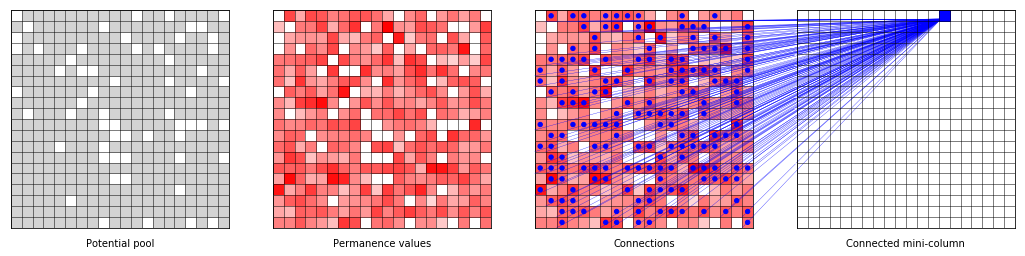

In [12]:
# blue dots should only be where above connection threshold....
# get bit from input space, and which cols are mapped
# check out how many cols overlap 
# interested for input space, if I have a random input, what is its overlap to mini column mapping

column_of_interest = s1.columns[mini_column_choice ]
min_permanence_value = min(s1.columns[mini_column_choice ]['potential_connections_permanence_values'])
max_permanence_value = max(s1.columns[mini_column_choice ]['potential_connections_permanence_values'])
column_coords = hc.convert_sdr_to_tuple_for_visualisation([mini_column_choice ], bit_space_size_choice)[0]


fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(18, 4))

ax1 = hc.create_axis_for_sdr(ax1, np.sqrt(bit_space_size_choice) + 1, np.sqrt(bit_space_size_choice) + 1, number_of_bits_used_to_encode_value_choice, "Potential pool")
ax2 = hc.create_axis_for_sdr(ax2, np.sqrt(bit_space_size_choice) + 1, np.sqrt(bit_space_size_choice) + 1, number_of_bits_used_to_encode_value_choice, "Permanence values")
ax3 = hc.create_axis_for_sdr(ax3, np.sqrt(bit_space_size_choice) + 1, np.sqrt(bit_space_size_choice) + 1, number_of_bits_used_to_encode_value_choice, "Connections")
ax4 = hc.create_axis_for_sdr(ax4, np.sqrt(bit_space_size_choice) + 1, np.sqrt(bit_space_size_choice) + 1, number_of_bits_used_to_encode_value_choice, "Connected mini-column")

coords1 = hc.convert_sdr_to_tuple_for_visualisation(column_of_interest['potential_connections'], bit_space_size_choice)
coords2 = hc.convert_sdr_to_tuple_for_visualisation(column_of_interest['connected_columns'], bit_space_size_choice)

p1 = [ax1.add_patch(Rectangle(coords1[i], 1, 1, color = "lightgray")) for i in range(len(coords1))]
p1 = [ax2.add_patch(Rectangle(coords1[i], 1, 1, color = compute_color(column_of_interest['potential_connections_permanence_values'][i], min_permanence_value, max_permanence_value))) for i in range(len(coords1))]
p1 = [ax3.add_patch(Rectangle(coords1[i], 1, 1, color = compute_color(column_of_interest['potential_connections_permanence_values'][i], min_permanence_value, max_permanence_value))) for i in range(len(coords1))]
p3 = [ax3.add_patch(Circle(offset_coords_for_visualisation(coords2[i], .5), .2, color = "blue")) for i in range(len(coords2))]


p3 = ax4.add_patch(Rectangle(column_coords, 1, 1, color = "blue"))
p3 = [ax4.add_artist(ConnectionPatch(xyA=offset_coords_for_visualisation(column_coords, .2), xyB=coords2[i], coordsA="data", coordsB="data",
                       axesA=ax4, axesB=ax3, color="blue", linewidth = 0.3)) for i in range(len(coords2))]

plt.savefig("./Images/spatial_pooler_columns.svg", dpi = 300)

<div style="background:#99ddff; color:black; padding: 10px">
<b>Add to these notes:</b>
    <br/>
<div>I love matplotlib, but sometimes rendering really high quality images directly is difficulty NOte that can also write image svg files. Just an aside to say this quite I created one with the last line of code
    </div>
    <img src = "Images/spatial_pooler_columns.svg"></img>
</div>


So far we have set this up, so its mini-column is connected a potential pool. Another way to visualise this is, for any bit in the input space, which columsn is it connected to?

Now let's look at some input. Before I do this however, I am going to create an SDR class as well. The reason for this, is that SDR is really not just the following function:

In [13]:
np.array(hc.create_randomised_sdr(400, 20))

array([259, 390, 140, 145, 285, 158,  33,  34, 307,  52,  55, 193, 321,
       323, 331, 206, 337, 343, 364, 380])

But an SDR is not just 20 random inputs, it is something a little more nuanced. For instnace, SDR knows about its toal input space, and its sparsity, so its like an array with certain attributes. This is a small thing, but as we go forward it will help us

Let's just create an object to manage an SDR

In [14]:
class SDR:
    def __init__(self, input_space_size, number_of_active_bits, label):
        self.input_space_size = input_space_size
        self.number_of_active_bits= number_of_active_bits
        self.active_bits = hc.create_randomised_sdr(self.input_space_size, self.number_of_active_bits)
        self.label = label
    def get_summary(self):
        print("----------------- SUMMARY -------------------------")
        print("|L1| Label:", self.label)
        print("|L1| Input space size of SDR:", self.input_space_size)
        print("|L2| Number of active bits in SDR:", self.number_of_active_bits)
        print("|L3| Percentage of active bits:", (self.number_of_active_bits / self.input_space_size) * 100, "%")
        print("|L3| Active bits:", self.active_bits)

In [15]:
sd1 = SDR(400, 20, "some_label")
sd1.get_summary()

----------------- SUMMARY -------------------------
|L1| Label: some_label
|L1| Input space size of SDR: 400
|L2| Number of active bits in SDR: 20
|L3| Percentage of active bits: 5.0 %
|L3| Active bits: [135, 141, 14, 143, 152, 281, 47, 183, 57, 76, 335, 79, 80, 83, 212, 94, 100, 359, 112, 252]


Now back to the Spatial Pooler. Let's create a version 2 and this version will allow us to pass an input in and see which columns that it is connected to. We will also add a few more features to it to bring out other properties:

In [16]:
input_space_size = 400
active_bits_in_inputs = 32

class SpatialPoolerV2:
    def __init__(self):
        self.input_space_size = 400
        self.potential_pool = .40
        self.connection_threshold = 0.1
        self.connection_threshold_sd = 0.01
        self.columns = {}
        self.connected_columns = None
        self.non_connected_columns = None
        self.connected_columns_permanence_values = None
        self.columns_initialised = False
        self.inputs  = []
        self.input_active_bits = None
        
    def add_inputs(self, inputs, multiple = True):
        self.inputs = inputs
        
    def compare_input_space_bits_to_mini_columns(self):
        pass
        
    def compare_inputs_to_connected_columns(self):
        for i in range(len(self.inputs)):
            for key, value in self.columns.items():
                overlap = list(set(value['connected_columns']).intersection(self.inputs[i].active_bits))
                print("The input at",self.inputs[i].label, "has an overlap score of", len(overlap), "with mini-column", str(key))
        
    def get_summary(self):
        print("----------------- SUMMARY -------------------------")
        print("|L1| Capacity of mini-columns in spatial pooler:", self.input_space_size)
        print("|L2| Potential pool of each minicolumn:", self.potential_pool * 100, "%")
        print("|L2| Connection threshold:", self.connection_threshold)
        print("|L2| Connection threshold standard deviation:", self.connection_threshold_sd)
        print("|L4| Columns initialised:", self.columns_initialised)
        print("|L5| Current number of inputs:", len(self.inputs))
        
    
        
    def initialise_columns_to_input_space(self):
        start_time = timer.perf_counter()
        potential_pool_size = int(self.potential_pool * self.input_space_size)

        for i in range(self.input_space_size):
        
            potential_connections = hc.create_randomised_sdr(self.input_space_size, potential_pool_size)
            non_connected_columns = [x for x in range(0, self.input_space_size) if x not in potential_connections]
            potential_connections_permanence_values = np.random.normal(self.connection_threshold, 0.01, potential_pool_size)
            connected_columns = []
            for j in range(0, len(potential_connections)):
                if potential_connections_permanence_values[j] > 0.1:
                    connected_columns.append(potential_connections[j])
                    
            self.columns[i] = {'potential_connections': potential_connections,
                              'non_connected_columns': non_connected_columns,
                               'potential_connections_permanence_values': potential_connections_permanence_values,
                               'connected_columns': connected_columns
                              }
            self.columns_initialised = True
            end_time = timer.perf_counter()
        print("Each of the", self.input_space_size, "mini-columns in this Spatial Pooler has now each randomonly connected to", self.potential_pool, 
              "of bits in the input space. \nThe connection strength is normally distributed approximately between", min(self.columns[0]['potential_connections_permanence_values']),
             "and", max(self.columns[0]['potential_connections_permanence_values']), "with a mean of", self.connection_threshold, 
              "which also acts as a connection threshold",
             "\nThere are now" , len(self.columns[0]['connected_columns']), "connected columns. \nTime taken to initialise:", end_time - start_time, "seconds.")

        
s2 = SpatialPoolerV2()
s2.get_summary()
s2.initialise_columns_to_input_space()
random_inputs = [SDR(input_space_size,active_bits_in_inputs, "TimeStep_" + str(i)) for i in range(0,3)]
random_inputs[0].get_summary()
s2.add_inputs(random_inputs)
s2.get_summary()
s2.inputs[1].get_summary()
s2.compare_inputs_to_connected_columns()

----------------- SUMMARY -------------------------
|L1| Capacity of mini-columns in spatial pooler: 400
|L2| Potential pool of each minicolumn: 40.0 %
|L2| Connection threshold: 0.1
|L2| Connection threshold standard deviation: 0.01
|L4| Columns initialised: False
|L5| Current number of inputs: 0
Each of the 400 mini-columns in this Spatial Pooler has now each randomonly connected to 0.4 of bits in the input space. 
The connection strength is normally distributed approximately between 0.08036952912737262 and 0.13061086237584113 with a mean of 0.1 which also acts as a connection threshold 
There are now 84 connected columns. 
Time taken to initialise: 0.5574811999977101 seconds.
----------------- SUMMARY -------------------------
|L1| Label: TimeStep_0
|L1| Input space size of SDR: 400
|L2| Number of active bits in SDR: 32
|L3| Percentage of active bits: 8.0 %
|L3| Active bits: [3, 7, 138, 398, 275, 281, 282, 283, 27, 29, 42, 301, 57, 316, 62, 321, 329, 202, 330, 205, 339, 343, 216, 88

Let's try it out with another example. This time we will go up to an input space of 1024. We are start finding some performance issues now, and in the next version we will need reconsider a more vectorised style implementation, but in the interests of keeping things as inutitive as possible. We will start tracking the time involved however:

In [17]:
s2 = SpatialPoolerV2()
#s2.get_summary()
s2.inputs

[]

In [18]:
s2.initialise_columns_to_input_space()

Each of the 400 mini-columns in this Spatial Pooler has now each randomonly connected to 0.4 of bits in the input space. 
The connection strength is normally distributed approximately between 0.07103673265261137 and 0.12490377000018993 with a mean of 0.1 which also acts as a connection threshold 
There are now 75 connected columns. 
Time taken to initialise: 0.5310383999894839 seconds.


Now let's add some inputs. Eventually we will not want to store the inputs our encoder, but for now we will. Let's create 5 random inputs: 

In [19]:
random_inputs = [SDR(input_space_size,active_bits_in_inputs) for i in range(0,3)]

TypeError: __init__() missing 1 required positional argument: 'label'

In [ ]:
random_inputs[2].get_summary()

In [ ]:
s2.add_inputs(random_inputs)
s2.get_summary()